# Parallax effect

This tutorial wants to demonstrate the parallax effect observed at large incidence angle with low-Z sensor material.

It uses one of the reference image available in the test-suite of pyFAI, a diffraction frame of corrundum taken at ID13 with an Eiger detector operating at 13.4keV

## Initialization

In [1]:
%matplotlib widget
import time
import copy
import numpy
from matplotlib.pyplot import subplots
from scipy.sparse import csr_array, csc_array
import fabio
import pyFAI
from pyFAI.gui import jupyter
from pyFAI.test.utilstest import UtilsTest
from pyFAI.calibrant import get_calibrant
import pyFAI.ext.parallax_raytracing

kwargs = { "npt": 2000,                              # this is a lot of oversampling ... do not use with actual images.
           "method": ("no", "histogram", "cython"),  # without pixel splitting, results are correct despite ugly images.
           "unit":"2th_deg",
           "radial_range": (10, 40),
           "dummy": 4e9,
           "delta_dummy": 1e9}

print(f"Using pyFAI version {pyFAI.version}")
start_time = time.perf_counter()

Using pyFAI version 2026.1.0-dev0


## Display the image and the powder diffraction pattern

In [2]:
ai = pyFAI.load(UtilsTest.getimage("Eiger4M.poni"))
ai0 = copy.deepcopy(ai) # this integrator does not know about parallax effect !
ai0

Detector Eiger 4M	 PixelSize= 75µm, 75µm	 BottomRight (3)
Wavelength= 0.921816 Å
SampleDetDist= 1.625582e-01 m	PONI= 9.632499e-02, 8.636842e-02 m	rot1=0.004596  rot2=0.000846  rot3=-0.000000 rad
DirectBeamDist= 162.560 mm	Center: x=1141.617, y=1286.167 pix	Tilt= 0.268° tiltPlanRotation= 169.572° λ= 0.922Å

In [3]:
alumine = get_calibrant("alpha_Al2O3")
alumine.wavelength = ai.wavelength

In [4]:
# Define sensor info to enable parallax:
ai.enable_parallax(True, sensor_material="Si", sensor_thickness=450e-6)
ai.detector.sensor = ai.parallax.sensor
ai

Detector Eiger 4M	 PixelSize= 75µm, 75µm	 BottomRight (3)	 Thin sensor with µ=4108.472 1/m, thickness=0.00045m and efficiency=0.843
Wavelength= 0.921816 Å	Parallax: µ= 41.085 cm⁻¹
SampleDetDist= 1.625582e-01 m	PONI= 9.632499e-02, 8.636842e-02 m	rot1=0.004596  rot2=0.000846  rot3=-0.000000 rad
DirectBeamDist= 162.560 mm	Center: x=1141.617, y=1286.167 pix	Tilt= 0.268° tiltPlanRotation= 169.572° λ= 0.922Å

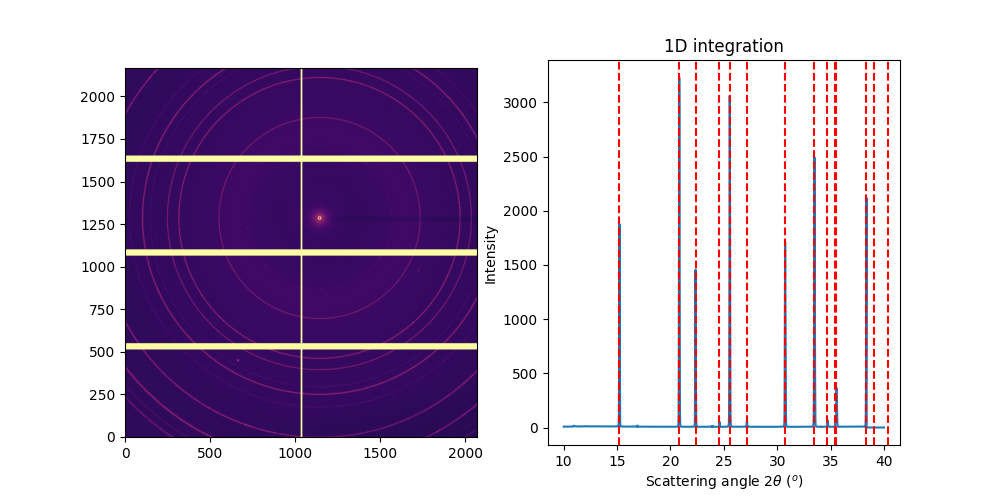

In [5]:
fig,ax = subplots(1,2, figsize=(10,5))
img_ref = fabio.open(UtilsTest.getimage("Eiger4M.edf")).data
jupyter.display(img_ref, ax=ax[0])
jupyter.plot1d(ai0.integrate1d(img_ref, **kwargs), ax=ax[1], calibrant=alumine);

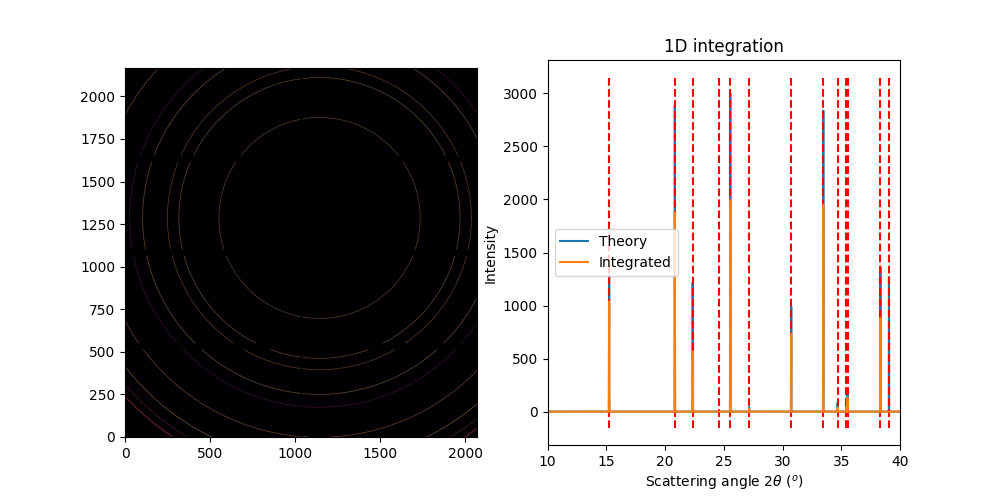

In [6]:
# prepare a synthetic dataset almost equivalent

ref_xrpd = alumine.fake_xrpdp(3000, (10,40), 
                              resolution=1e-2, # very fine resolution, finer than the pixel size
                              unit="2th_deg", 
                              Imax=3e3)
img_ref = ai0.calcfrom1d(   ref_xrpd.radial,
                            ref_xrpd.intensity,
                            mask=ai.detector.mask)
reintegrated = ai0.integrate1d(img_ref, **kwargs)

fig,ax = subplots(1,2, figsize=(10,5))
jupyter.display(img_ref, ax=ax[0])
jupyter.plot1d(ref_xrpd, ax=ax[1], calibrant=alumine, label="Theory")
ax[1].plot(*reintegrated, label="Integrated")
ax[1].set_xlim(10, 40)
ax[1].legend();

## Calculate the bluring operator as a sparse matrix

In [7]:
rt = pyFAI.ext.parallax_raytracing.Raytracing(ai, buffer_size=32)

In [8]:
%%time 
sparse = csc_array(rt.calc_csr(32),  # throw 32x32=1024 rays per pixel ... can take a while
                   shape =(img_ref.size, img_ref.size))

CPU times: user 8min 45s, sys: 967 ms, total: 8min 46s
Wall time: 11.5 s


Apply parallax bluring on the image as sparse matrix multiplication:

In [9]:
img_par = sparse.dot(img_ref.ravel()).reshape(img_ref.shape)

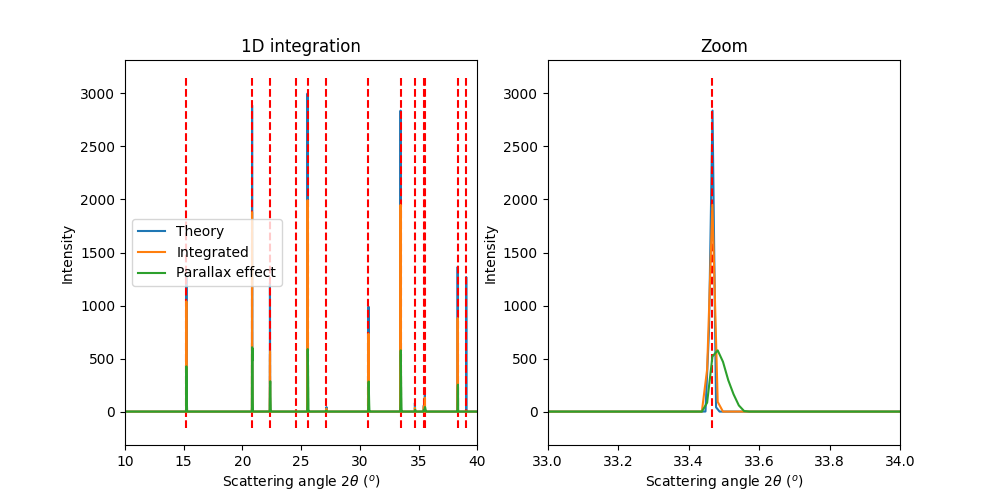

In [10]:
res0 = ai0.integrate1d(img_ref, **kwargs)
res1 = ai0.integrate1d(img_par, **kwargs)

fig,ax = subplots(1,2, figsize=(10,5))
jupyter.plot1d(ref_xrpd, label="Theory", ax=ax[0], calibrant=alumine)
jupyter.plot1d(ref_xrpd, ax=ax[1], calibrant=alumine)
ax[0].plot(*res0, label="Integrated")
ax[1].plot(*res0, label="Integrated")
ax[0].plot(*res1, label="Parallax effect")
ax[1].plot(*res1, label="Parallax effect")
ax[0].set_xlim(10, 40)
ax[1].set_xlim(33, 34)
ax[1].set_title("Zoom")
ax[0].legend();

## Correction of the parallax effect within the integrator

In [11]:
# Use the sensor material aware azimuthal integrator:
res2 = ai.integrate1d(img_par, **kwargs)

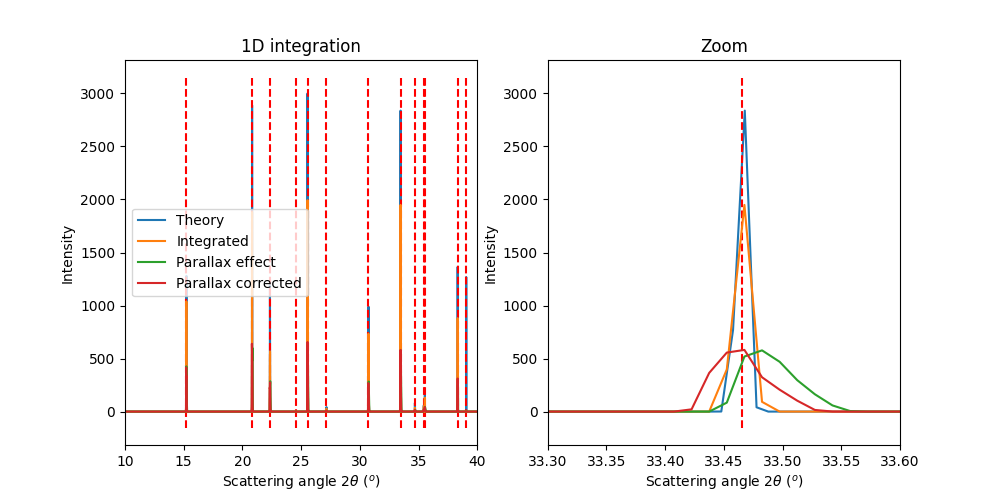

In [12]:
fig,ax = subplots(1,2, figsize=(10,5))
jupyter.plot1d(ref_xrpd, label="Theory", ax=ax[0], calibrant=alumine)
jupyter.plot1d(ref_xrpd, ax=ax[1], calibrant=alumine)
ax[0].plot(*res0, label="Integrated")
ax[1].plot(*res0, label="Integrated")
ax[0].plot(*res1, label="Parallax effect")
ax[1].plot(*res1, label="Parallax effect")

ax[0].plot(*res2, label="Parallax corrected")
ax[1].plot(*res2, label="Parallax corrected")

ax[0].set_xlim(10,40)
ax[1].set_xlim(33.3, 33.6)

ax[1].set_title("Zoom")
ax[0].legend();

As one can see, when the parallax correction is activated in the geometry/azimuthal integrator, the peak position (maximum) is shifted to the right position. But it does not deconvolve the peak shape which remains distorted.

## Conclusion
PyFAI provides tools to simulate the parallax effect using raytracing.
The sparse matrix obtained can be used to blurr a diffraction image and later on to "deconvolute" using iterative methods like MLEM.
It is in addition able to take the volumic absorption effect into account to correct the peak position.

In [13]:
print(f"Runtime: {time.perf_counter() - start_time:.3f}s")

Runtime: 15.361s
